- Ana Sofía Escobar
- Wilfredo Gallegos
- Stefan Quintana
- Jorge Caballeros

# Proyecto Final - Mineria de datos

In [220]:
import pandas as pd
import numpy as np
import scipy.stats as st
import itertools
import statsmodels.api as sm
from scipy.stats import contingency
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import plot_tree
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree

from tensorflow.keras.models import Model, Sequential, load_model, save_model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras import optimizers
 
#Metrics
from sklearn.metrics import make_scorer, accuracy_score,precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score ,precision_score,recall_score,f1_score

plt.style.use('ggplot')

In [221]:
# Cargar los datos
muertes = pd.read_csv('final.csv')
# Quitar causa de muerte y edad ya que es información no necesaria
muertes = muertes.loc[:, muertes.columns != 'Tiempo']
muertes = muertes.loc[:, muertes.columns != 'Causa2']

C:\Users\anaso\AppData\Local\Temp\ipykernel_23608\3310959997.py:2: DtypeWarning: Columns (0,7,12,18,22,26) have mixed types. Specify dtype option on import or set low_memory=False.
  muertes = pd.read_csv('final.csv')


In [222]:
#Organizar los datos por columnas y causas
muertes['cause'] = muertes['Causa1'].copy()
repl = {r'([AB])(\d+.*)' : r'AB', r'(C)(\d+.*)' : r'CD',  r'(D[0-4])(\d+.*)' : r'CD', r'(D[5-8])(\d+.*)' : r'DD', r'(E)(\d+.*)' : r'EE',
        r'(F)(\d+.*)' : r'FF', r'(G)(\d+.*)' : r'GG', r'(H[0-5])(\d+.*)' : r'HA', r'(H[6-9])(\d+.*)' : r'HB', r'(I)(\d+.*)' : r'II',
        r'(J)(\d+.*)' : r'JJ', r'(K)(\d+.*)' : r'KK', r'(L)(\d+.*)' : r'LL', r'(M)(\d+.*)' : r'MM', r'(N)(\d+.*)' : r'NN',
        r'(O)(\d+.*)' : r'OO', r'(P)(\d+.*)' : r'PP', r'(Q)(\d+.*)' : r'QQ', r'(R)(\d+.*)' : r'RR', r'([ST])(\d+.*)' : r'ST',
        r'([VWXY])(\d+.*)' : r'VY', r'([Z])(\d+.*)' : r'ZZ', r'([U])(\d+.*)' : r'UU',
        }
muertes.cause = muertes['cause'].replace(repl, regex=True)
muertes['cause']

0         II
1         UU
2         RR
3         PP
4         UU
          ..
809291    AB
809292    AB
809293    AB
809294    AB
809295    AB
Name: cause, Length: 809296, dtype: object

In [223]:
# Eliminación de toda la información que no nos interesa
muestra = muertes.drop(['Coma', 'Departamento', 'Municipio', 'Mes', 'Year','Municipio2',
                      'Edad','Pueblo','Civil','Escolaridad','Ciudad','Pais','Dep3',
                      'Muni3', 'Pais2', 'Predif', 'Dredif', 'Mredif', 'Sexo', 'Causa1'], axis=1)

In [224]:
# Creación de la nueva variable de predicción
# Variable de predicción: número de muertes por municipio_ocurrencia/mes_ocurrencia y causa
muestra = muestra.groupby(by=['cause','Departamento2', 'Mes2', 'Dia', 'Year2', 'Asistencia', 
                            'Lugar', 'Certifica']).count()
muestra.columns = ['number_deaths']

In [225]:
# Nuevo conjunto de datos
muestra = muestra.reset_index(level=['cause', 'Mes2', 'Dia', 'Year2', 'Asistencia', 'Lugar','Certifica','Departamento2'])

<AxesSubplot: xlabel='number_deaths', ylabel='Count'>

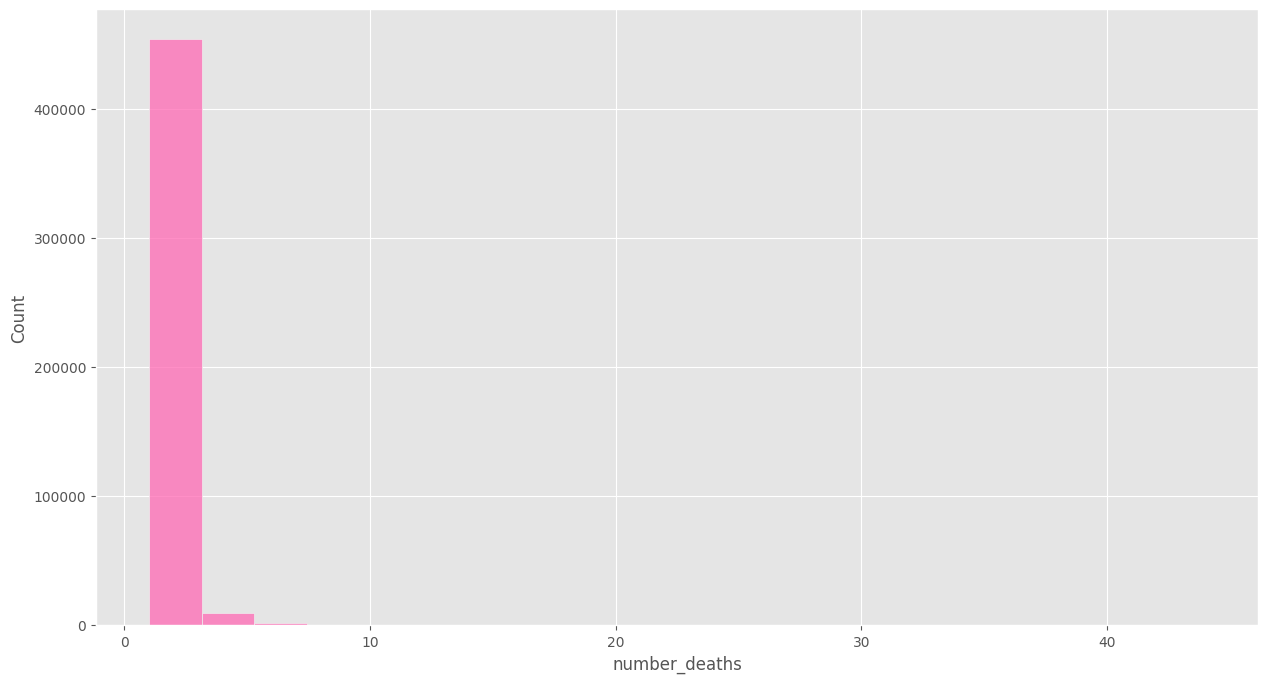

In [226]:
#Gráfica de la distribución de la variable objetivo
plt.figure(figsize=(15, 8))
sns.histplot(muestra.number_deaths, color = 'hotpink')

Se observa como el numero de muertes esta bastante sesgado lo que indica que hay una correlación bastante grande dentro de nuestras variables. 

In [227]:
# Evaluar la correlación de las variables
for column in muestra.columns:
  if column != 'cause':
    crosstable = pd.crosstab(muestra[column], muestra['cause'])
    print(crosstable)
    print('Asociación: ', contingency.association(crosstable))

cause             AB     CD    DD     EE   FF    GG  HA  HB     II    JJ  \
Departamento2                                                              
Alta Verapaz    3803   2168   658   2954   64   522   5   4   3012  4864   
Baja Verapaz     415    913    50    722   29   152   3   0   1751  1081   
Chimaltenango    692   1863   147   1773  202   270   0   0   2516  2631   
Chiquimula       567   1278   113   1105   35   260   0   0   2627  1597   
El Progreso      143    845    21    682   16   110   0   0   1550   550   
Escuintla       1461   2608   452   3551  105   610   0   3   4155  2733   
Guatemala       5622  11898  1553  10864  955  3477   5   7  13917  9582   
Huehuetenango   2438   3128   236   2692  117   749   1   2   4019  4165   
Izabal           930   1092   136   1227   29   250   0   1   2300  1021   
Jalapa           559   1125    60    731   28   334   0   0   1876  1205   
Jutiapa          411   1903    96   1568   54   287   1   0   4042  1132   
Peten       

In [228]:
# Eliminando las variables correlacionadas
muestra = muestra.drop(['Asistencia', 'Dia', 'Certifica'], axis=1)

# Agrupando nuevamente
muestra = muestra.groupby(['cause', 'Lugar','Departamento2', 'Year2', 'Mes2']).count()
muestra = muestra.reset_index(level=['cause', 'Lugar','Departamento2', 'Year2', 'Mes2'])

0        1
1        1
2        1
3        1
4        1
        ..
83817    1
83818    3
83819    1
83820    1
83821    2
Name: number_deaths, Length: 83822, dtype: int64

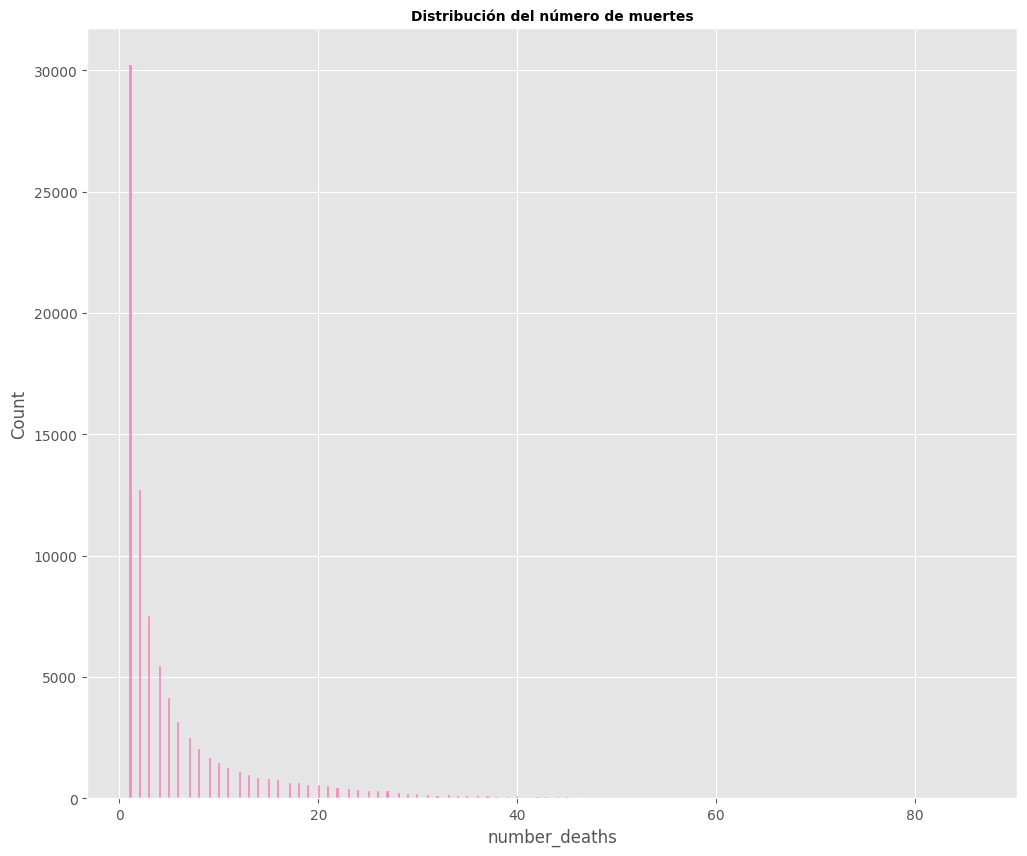

In [229]:
plt.figure(figsize=(12, 10))
sns.histplot(muestra.number_deaths, color = 'hotpink')
plt.title('Distribución del número de muertes', fontsize = 10, fontweight = "bold")
muestra.number_deaths

Observamos como las causas de muerte ya no se encuentran tan sesgadas dentro de nuestro conjunto de datos.

In [230]:
# Codificación de las variables
codificacion = OrdinalEncoder(dtype=int)
for column in muestra.columns:
        if column != 'number_deaths':
                muestra[column] = codificacion.fit_transform(muestra[[column]])

In [231]:
# Variables  predecir
target = muestra.number_deaths
predecidos = muestra.loc[:, muestra.columns != 'number_deaths']
# Conjuntos de entrenamiento y prueba
predictors_train, predictors_test, target_train, target_test = train_test_split(predecidos, target, test_size=0.33,
                                                                                stratify=predecidos['cause'], random_state=190243)

# Redes neuronales

In [232]:
predecidos

,cause,Lugar,Departamento2,Year2,Mes2
0,0,0,0,1,0
1,0,0,0,1,8
2,0,0,0,3,1
3,0,0,0,3,6
4,0,0,0,4,6
...,...,...,...,...,...
83817,19,8,26,9,6
83818,19,8,26,9,8
83819,19,8,26,9,9
83820,19,8,26,9,10


In [233]:
#Forma de los datos
print('Train')
print('Predecidos: ', predictors_train.shape, 'Objetivo:', target_train.shape)
print('Test')
print('Predecidos: ', predictors_test.shape, 'Objetivo:', target_test.shape)

sample_shape = predictors_train.shape[1:]
print('Data shape:', sample_shape)

Train
Predecidos:  (56160, 5) Objetivo: (56160,)
Test
Predecidos:  (27662, 5) Objetivo: (27662,)
Data shape: (5,)


In [234]:
# Creamos el modelo de la red neuronal con capas
def create_network():
    input = Input(shape=sample_shape, name='input')
    process = Dense(64, activation='relu', name='dense2')(input)
    process = Dense(16, activation='relu', name='dense3')(process)
    dropout = Dropout(0.15, name='dropout')(process)
    process = Dense(8, activation='relu', name='dense4')(process)
    process = Dense(1, activation=None, name='regressor')(process)
    # Creación del modelo
    nn_model = Model(input, process, name='Number_deaths')
    # Compilando el modelo
    optimizer = optimizers.Adam(learning_rate=1e-4, epsilon=1e-6)
    nn_model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return nn_model

In [235]:
modelo1 = create_network()
# Entrenamiento de las redes
history = modelo1.fit(predictors_train, target_train, epochs=40, batch_size=128, validation_split=0.15)

Epoch 1/40
373/373 [==============================] - 3s 4ms/step - loss: 63.0101 - mae: 4.8946 - val_loss: 61.5881 - val_mae: 4.9841
Epoch 2/40
373/373 [==============================] - 1s 3ms/step - loss: 61.2678 - mae: 4.9567 - val_loss: 60.5269 - val_mae: 4.9557
Epoch 3/40
373/373 [==============================] - 1s 3ms/step - loss: 60.2680 - mae: 4.9234 - val_loss: 59.6503 - val_mae: 4.9890
Epoch 4/40
373/373 [==============================] - 1s 3ms/step - loss: 59.4219 - mae: 4.8991 - val_loss: 58.8988 - val_mae: 4.9381
Epoch 5/40
373/373 [==============================] - 1s 3ms/step - loss: 58.7467 - mae: 4.8737 - val_loss: 58.2891 - val_mae: 4.8862
Epoch 6/40
373/373 [==============================] - 1s 3ms/step - loss: 58.1672 - mae: 4.8437 - val_loss: 57.7277 - val_mae: 4.9061
Epoch 7/40
373/373 [==============================] - 1s 3ms/step - loss: 57.5997 - mae: 4.8317 - val_loss: 57.1747 - val_mae: 4.7978
Epoch 8/40
373/373 [==============================] - 1s 3ms/s

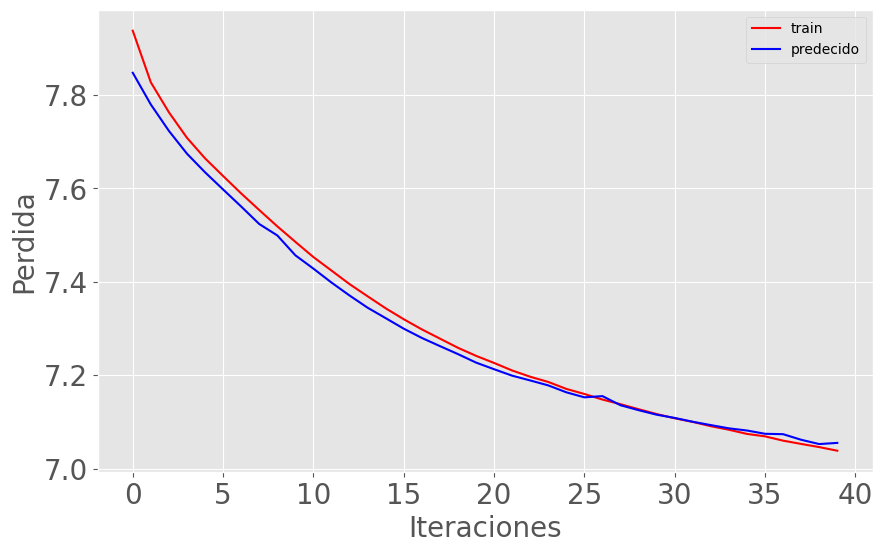

In [236]:
#Grafico de comparacion entre el objetivo y la prediccion
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(history.history['loss']), 'r', label='train')
ax.plot(np.sqrt(history.history['val_loss']), 'b' ,label='predecido')
ax.set_xlabel(r'Iteraciones', fontsize=20)
ax.set_ylabel(r'Perdida', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

Se observa como a medida que aumentan las iteraciones hay menor perdida lo que indica que el modelo esta avanzando y hay una mejor representación de los datos. 

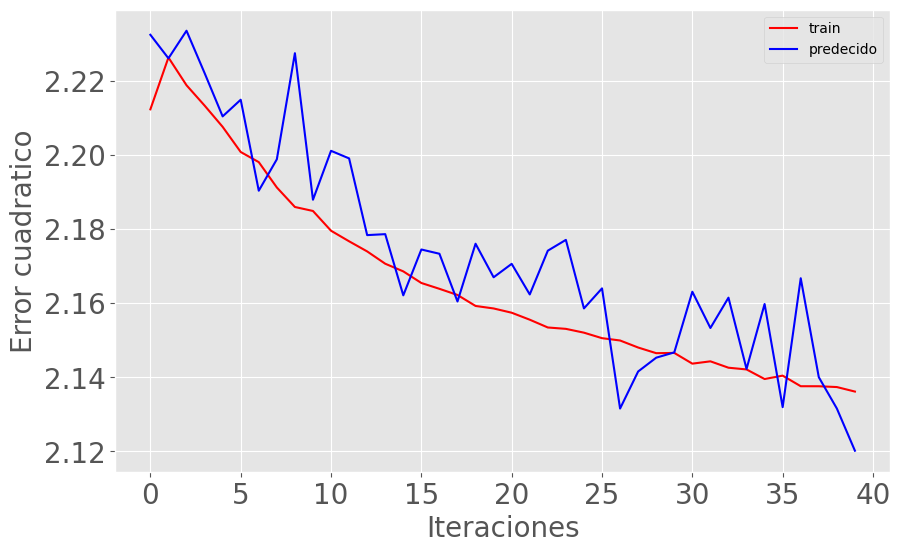

In [237]:
#Gráfico de precisión
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(history.history['mae']), 'r', label='train')
ax.plot(np.sqrt(history.history['val_mae']), 'b' ,label='predecido')
ax.set_xlabel(r'Iteraciones', fontsize=20)
ax.set_ylabel(r'Error cuadratico', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

Se observa bastantes fluctuaciones con respecto al error cuadratico del modelo predecido pero se observa como este va disminuyendo a medida que aumentan las iteraciones, esto significa que el modelo es sensible o puede significar una señal de sobreajuste de los datos. 

In [238]:
#Predicciones
predict1 = modelo1.predict(predictors_test)
predict1 = np.squeeze(predict1)

865/865 [==============================] - 1s 2ms/step


In [242]:
results = pd.DataFrame({
    'Predicción': predict1,
    'Real': target_test
})

print ("Varianza:",explained_variance_score(target_test, predict1))
print ("Mean absolute Error:", mean_absolute_error(target_test, predict1))
print ("Mean squared error:", mean_squared_error(target_test, predict1))

results.tail(10)

Varianza: 0.14364908629872952
Mean absolute Error: 4.5184634851815515
Mean squared error: 51.739666591882546


,Predicción,Real
24975,3.341105,2
1048,9.916309,8
71415,6.331491,7
13642,1.455389,1
23876,8.669071,2
49532,6.340782,1
28526,8.918851,8
12023,7.620844,2
48855,4.573133,2
69882,3.441740,1


La varianza indica que hay consistencia entre los valores predecidos y los reales, también que las predicciones de la media estan bastante agrupadas cerca de la media. 

# Random Forest

In [ ]:
# Multicolinealidad de las variables
datarandfor = pd.DataFrame() 
G = muestra
datarandfor["Variable"] = G.columns
datarandfor["VIF"] = [variance_inflation_factor(G.values, i) for i in range(len(G.columns))]
print(datarandfor)

        Variable       VIF
0          cause  3.128978
1          Lugar  2.650745
2  Departamento2  2.632861
3          Year2  2.859140
4           Mes2  2.864286
5  number_deaths  1.428708


Observamos como ninguna variable muestra indicios de estar correlacionada por lo que procedemos a realizar las predicciones.

In [ ]:
predictors_train, predictors_test, target_train, target_test = train_test_split(predecidos, target, test_size=0.33, stratify=predecidos['cause'])
print(predictors_train)

       cause  Lugar  Departamento2  Year2  Mes2
38757      9      3              8      0     0
76033     19      3             13      1     8
2374       0      1             25      6     2
40671      9      6              6      8     1
58563     15      1             25      6    10
...      ...    ...            ...    ...   ...
69029     17      3              2      5     0
28773      8      1             19      1     4
6285       1      1              6      4     8
73862     19      1             24      1     8
38905      9      3              9      6     2

[56160 rows x 5 columns]


In [ ]:
#creamos el modelo random forest
modelo2 = RandomForestRegressor(n_estimators=50, max_depth=15, random_state = 1000)
modelo2.fit(predictors_train,target_train)

RandomForestRegressor(max_depth=15, n_estimators=50, random_state=1000)

In [ ]:
#prediccion del modelo
predict2 = modelo2.predict(predictors_test)
predict22 = modelo2.predict(predictors_train)

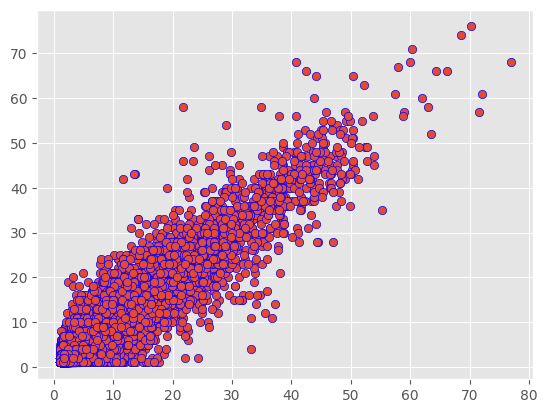

In [ ]:
#grafico de la predicción
plt.scatter(predict2, target_test, edgecolors=(0, 0, 1))

Se observa como las variables predichas estan bastante cerca de las reales lo que indica que hay un buen ajuste de los datos. 

In [ ]:
#calculamos R^2 y estadisticos necesarios
print("R cuadrado: %.2f"%r2_score(target_test,predict2))
print("R cuadrado teórico: %.2f"%r2_score(target_train,predict22))
print ("Varianza:",explained_variance_score(target_test, predict2))
print ("Mean absolute Error:", mean_absolute_error(target_test, predict2))
print ("Mean squared error:", mean_squared_error(target_test, predict2))

R cuadrado: 0.88
R cuadrado teórico: 0.95
Varianza: 0.8781081912818085
Mean absolute Error: 1.6347733668298898
Mean squared error: 7.137847035575808


El R cuadrado nos muestra que las predicciones son bastante acertadas sin embargo el R teórico es mayor lo que indica que aun se puede mejorar el modelo. La varianza indica de igual forma que los datos estan relativamente agrupados a la media lo que indica una prediccion buena. 

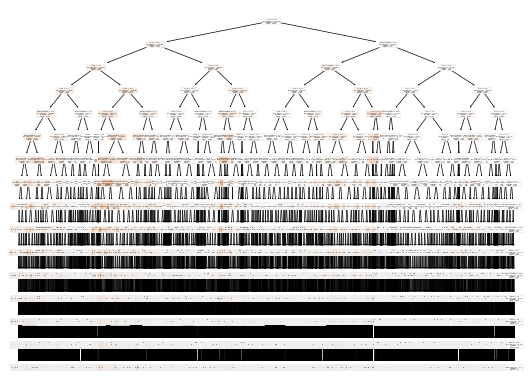

In [ ]:
#graficamos el random forest
plt.figure()
_ = tree.plot_tree(modelo2.estimators_[0], feature_names=G.columns, filled=True)

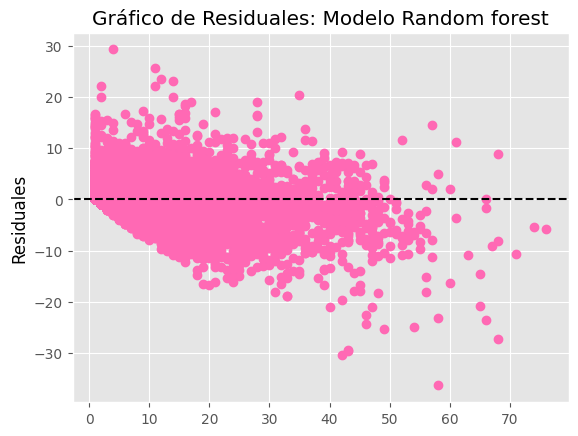

In [ ]:
#calculamos los residuos
residuales = predict2 - target_test

#graficamos
plt.plot(target_test,residuales, 'o', color='hotpink')
plt.title("Gráfico de Residuales: Modelo Random forest")
plt.ylabel("Residuales", color=  'black')
plt.axhline(y = 0, linestyle = '--', color = 'black')
plt.show()

Los residuos estan repartidos de manera aleatorio al rededor de cero lo que indica que no hay correlación entre variables. 

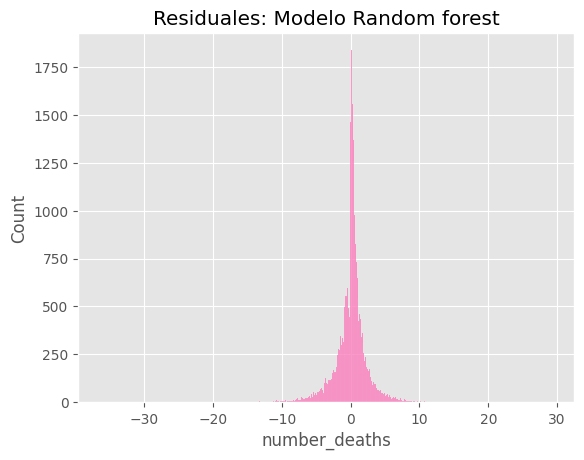

In [ ]:
sns.histplot(residuales, color='hotpink');
plt.title("Residuales: Modelo Random forest")
plt.show()

Se osberva una distribución normal en los residuales del modelo y no se observan muchos datos atipicos.

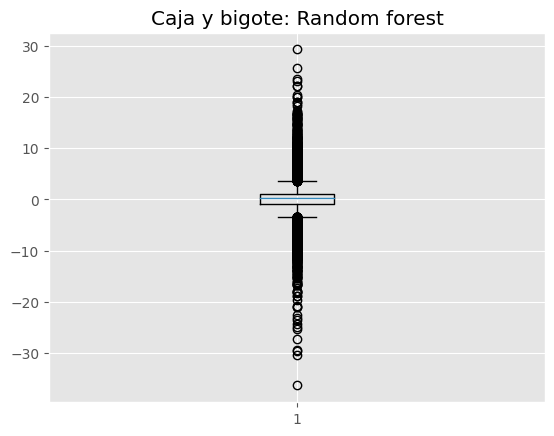

In [ ]:
plt.boxplot(residuales)
plt.title('Caja y bigote: Random forest')
plt.show()

El grafico de cajas nos muestra como la mayoria de datos esta sesgado a cero y se observan algunos datos atipicos, pero si tomamos en cuenta el tamaño de la muestra no son significantes. 

# Árbol de decisión

In [ ]:
# Creando y entrenando el modelo
modelo3 = DecisionTreeRegressor(max_depth=12, random_state=42)
modelo3 = modelo3.fit(X=predictors_train, y=target_train)

In [ ]:
# Evaluando el modelo
predict3 = modelo3.predict(predictors_test)
results = pd.DataFrame({
    'Predicción': predict3,
    'real': target_test
})

print("Varianza:", explained_variance_score(target_test, predict3))
print("Mean absolute Error:", mean_absolute_error(target_test, predict3))
print("Mean squared error:", mean_squared_error(target_test, predict3))

Varianza: 0.8330222182388481
Mean absolute Error: 1.855952732585191
Mean squared error: 9.774556777282633


,Predicción,real
53715,2.402878,7
49517,1.666667,2
74436,1.000000,1
15324,7.322581,9
59250,10.764706,9
2470,4.980769,1
27768,26.100000,30
34317,1.708861,2
59939,2.661017,2
35493,38.875000,38


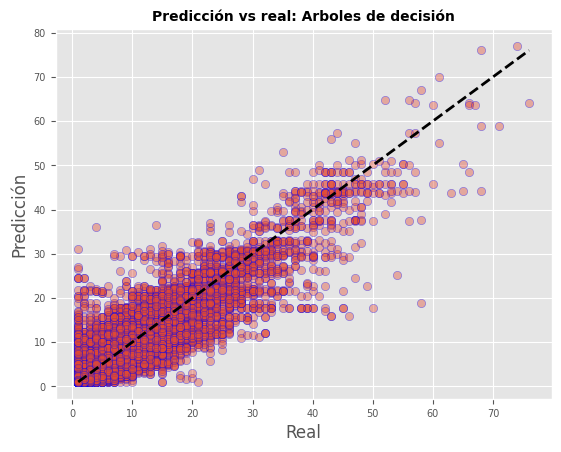

In [ ]:
# Comparación entre valores predichos y valores reales
plt.scatter(target_test, predict3, edgecolors=(0, 0, 1), alpha=0.4)
plt.plot([target_test.min(), target_test.max()], [target_test.min(), target_test.max()], 'k--', lw=2)
plt.title('Predicción vs real: Arboles de decisión', fontsize=10, fontweight="bold")
plt.xlabel('Real')
plt.ylabel('Predicción')
plt.tick_params(labelsize=7)

results.tail(10)

Se observa como los valores siguen una tendendcia lineal y se observa como los puntos se encuentran bastante cerca a los valores reales, esto indica que la predicción de los valores fue bastante buena. 

In [ ]:
#model residuals
residuals  = predict3 - target_test

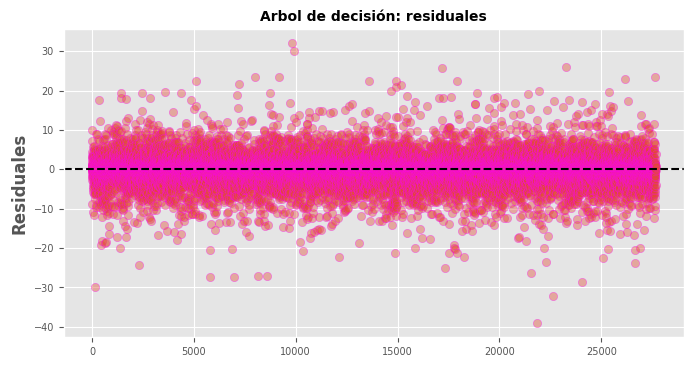

In [ ]:
#Eficiencia del modelo
plt.figure(figsize=(8, 4))

# Residuos Modelo 3
plt.scatter(list(range(len(predict3))), residuals,edgecolors=(1, 0, 1), alpha = 0.4)
plt.axhline(y = 0, linestyle = '--', color = 'black')
plt.title('Arbol de decisión: residuales', fontsize = 10, fontweight = "bold")
plt.ylabel('Residuales',fontweight = "bold")
plt.tick_params(labelsize = 7)
plt.show()

Se observa como los puntos se encuentran distribuidos de manera aleatoria al rededor de cero lo que indica que no hay correlacion entre los datos o casi ninguna correlacion. 